In [1]:
import numpy as np
import pandas as pd
import scipy as sp 
import sys 
import string
import random
import matplotlib.pyplot as plt
import multiprocessing as mp
import pandas as pd
import os
import pickle
import logging

# Importing other functions
import sys
sys.path.append(os.path.join('functions'))
from gamlass_main import *
from utils import *
from model_utils import *

# Setting and importing R functions
import os
os.environ["R_LIBS_USER"] = "/usr/local/lib/R/site-library"


import rpy2.robjects as ro
from rpy2.robjects.packages import importr
# Load the necessary R packages
gamlss = importr('gamlss')
base = importr('base')


# Auto-reload to reflect the real-time changes - quite useful for development of functions
%reload_ext autoreload
%autoreload 2


### To remove unneccesary warning messages
# import warnings
# warnings.filterwarnings("ignore")

from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)


#### Creating dataset for testing the functions

In [2]:
import numpy as np
import pandas as pd
import random
import string

# Function to generate random site ID
def generate_random_site_id(length, seed):
    random.seed(seed)
    letters = string.ascii_uppercase
    return ''.join(random.choice(letters) for _ in range(length))

# Generate train dataset
np.random.seed(42)
n_train = 1000
train_sites_seeds = [1, 2, 3, 4, 5]
train_sites = [generate_random_site_id(5, seed) for seed in train_sites_seeds]
age_train = np.random.randint(18, 80, n_train)
sex_train = np.random.choice([0, 1], size=n_train)
feature_volume_train1 = np.random.uniform(800, 1200, n_train)

y_thickness_train1 = 2 + 0.05 * age_train + 0.01 * feature_volume_train1 + 0.1 * sex_train + np.random.normal(0, 0.1, n_train)

train_data = {
    'site': np.random.choice(train_sites, size=n_train),
    'sex': sex_train,
    'age': age_train,
    'feature_volume1': feature_volume_train1,
    'y_thickness1': y_thickness_train1
}
train_data = pd.DataFrame(train_data)

# Generate test dataset
n_test = 800
test_sites_seeds = train_sites_seeds + [6, 7, 8, 9]  # Additional fixed seed for test site
test_sites = [generate_random_site_id(5, seed) for seed in test_sites_seeds]
new_site_bool = [test_site not in train_data['site'].unique() for test_site in test_sites]
new_site = np.array(test_sites)[new_site_bool]
print(f"New site: {new_site}")

age_test = np.random.randint(18, 80, n_test)
sex_test = np.random.choice([0, 1], size=n_test)
feature_volume_test1 = np.random.uniform(800, 1200, n_test)
site_test = np.random.choice(test_sites, size=n_test)

# Create y_thickness for test data
y_thickness_test1 = []
for i, test_site in enumerate(site_test):
    if test_site in train_data['site'].unique():
        y_thickness_test1.append(2 + 0.05 * age_test[i] + 0.01 * feature_volume_test1[i] + 0.1 * sex_test[i] + np.random.normal(0, 0.1))
    else:
        y_thickness_test1.append(5 + 0.05 * age_test[i] + 0.01 * feature_volume_test1[i] + 0.1 * sex_test[i] + np.random.normal(0, 0.3))

y_thickness_test1 = np.array(y_thickness_test1)
# Add outliers to the test data
morbidity_size = 200
outlier_indices = np.random.choice(n_test, size=morbidity_size, replace=False)
y_thickness_test1[outlier_indices[:(morbidity_size//2)]] += np.random.normal(3, 0.05, morbidity_size//2)  # Positive outliers for y_thickness1
y_thickness_test1[outlier_indices[(morbidity_size//2):]] -= np.random.normal(3, 0.001, morbidity_size//2)  # Negative outliers for y_thickness1

morbidities = ['None', 'Schizo', 'Dementia', 'MDD']
affected_test = np.full(n_test, 'None', dtype=object)
affected_test[outlier_indices] = np.random.choice(morbidities[1:], size=morbidity_size)  # Assign morbidities only to outliers



#affected_test = np.full(len(y_thickness_test1), 'None', dtype=object)

test_data = {
    'site': site_test,
    'sex': sex_test,
    'age': age_test,
    'feature_volume1': feature_volume_test1,
    'y_thickness1': y_thickness_test1,
    'affected': affected_test
}


test_data = pd.DataFrame(test_data)

# Print the datasets
print("Training Dataset:")
display(train_data.head())
print("\nTesting Dataset:")
display(test_data.head())

# Print information about the new site
new_site_data = test_data[test_data['site'].isin(new_site)]
print(f"\nNew Site ({new_site}) Data:")
print(new_site_data.describe())

# Print information about the new site
print(f"\nTrain Sites Data:")
print(train_data.describe())

# Print unique sites
print("\nUnique sites in training data:", train_data['site'].unique())
print("Unique sites in testing data:", test_data['site'].unique())

New site: ['ZSCPY' 'KEMUB' 'HLMEG' 'OTLIE']
Training Dataset:


,site,sex,age,feature_volume1,y_thickness1
0,ESZYC,0,56,848.209032,13.175779
1,ESZYC,0,69,1092.409469,16.387903
2,HJDXM,1,46,877.039611,13.144556
3,HJDXM,0,32,846.112808,12.153800
4,BCCLF,0,60,968.705064,14.735787



Testing Dataset:


,site,sex,age,feature_volume1,y_thickness1,affected
0,HJDXM,0,37,1012.542733,13.927363,None
1,HJDXM,0,52,958.311072,11.436548,Dementia
2,BCCLF,0,22,1045.260764,13.548618,None
3,OTLIE,0,26,1122.240888,17.101137,None
4,OTLIE,1,46,919.867474,16.558421,None



New Site (['ZSCPY' 'KEMUB' 'HLMEG' 'OTLIE']) Data:
              sex         age  feature_volume1  y_thickness1
count  373.000000  373.000000       373.000000    373.000000
mean     0.533512   49.415550      1003.465201     17.500278
std      0.499546   16.942867       115.766382      2.153749
min      0.000000   18.000000       800.830607     11.819449
25%      0.000000   35.000000       901.593901     16.126728
50%      1.000000   49.000000      1005.304202     17.378537
75%      1.000000   64.000000      1101.247539     18.906644
max      1.000000   79.000000      1199.619799     23.092077

Train Sites Data:
               sex          age  feature_volume1  y_thickness1
count  1000.000000  1000.000000      1000.000000   1000.000000
mean      0.477000    49.857000       997.722567     14.525074
std       0.499721    18.114267       114.789096      1.494410
min       0.000000    18.000000       800.095009     11.049746
25%       0.000000    35.000000       894.786788     13.420992
50

In [3]:
# function = robjects.r('''gamlss''')
# print(function)

In [4]:
test_data['site'].unique()

array(['HJDXM', 'BCCLF', 'OTLIE', 'ZSCPY', 'HLMEG', 'ESZYC', 'KEMUB',
       'HSREL', 'TIXLZ'], dtype=object)

In [5]:
check_test_sites(train_data, test_data)

Number of unique sites in the training set: 5
Number of unique sites in the test set: 9
Test sites not present in the training set: ['ZSCPY', 'KEMUB', 'HLMEG', 'OTLIE']
Number of extra sites: 4


,site,Length,Healthy,Morbidities
0,ZSCPY,93,71,"Len: 22, ['MDD', 'Schizo', 'Dementia']"
1,KEMUB,97,70,"Len: 27, ['Schizo', 'Dementia', 'MDD']"
2,HLMEG,92,66,"Len: 26, ['MDD', 'Dementia', 'Schizo']"
3,OTLIE,91,71,"Len: 20, ['Schizo', 'MDD', 'Dementia']"


Suggestion: Use 20% of 'None' samples from extra sites in the training data.
This can be done by calling the 'add_extra_site_data' function.


In [6]:
train_data.to_csv('../extra_files/train_data_sitetransfer.csv', index=False)
test_data.to_csv('../extra_files/test_data_sitetransfer.csv', index=False)
df2=test_data.copy()

#### Fitting the model

In [7]:
# Defining x and y variables for GAMLASS
y_val = 'y_thickness1'
x_vals = ['age', 'sex', 'site']
columns = x_vals.copy()
columns.extend([y_val])

# Selecting the columns for the training data
df1 = train_data.loc[:, columns]

# Create an instance of the Gamlss class
model_name = 'main_model'
gamlss_model = Gamlss(model_name, x_vals, y_val)

gamlss_model.fit(
    r_code="""
    model <- gamlss(y ~ pb(age, by = as.factor(sex)) + site,
        sigma.formula = ~ pb(age) + site,
        nu.formula = ~ 1,
        tau.formula = ~ 1,
        random = ~ 1|site,
        family = SHASH(),
        method = RS(100)
    )
    """,
    data=df1
)
# family = SHASH(), GG()
# method = RS(2), CG(10), mixed(2,10)
# "by="  function means separate smoothing term for each sex

GAMLSS-RS iteration 1: Global Deviance = 3419.122 
GAMLSS-RS iteration 2: Global Deviance = 3345.641 
GAMLSS-RS iteration 3: Global Deviance = 3291.316 
GAMLSS-RS iteration 4: Global Deviance = 3249.32 
GAMLSS-RS iteration 5: Global Deviance = 3216.318 
GAMLSS-RS iteration 6: Global Deviance = 3189.295 
GAMLSS-RS iteration 7: Global Deviance = 3167.3 
GAMLSS-RS iteration 8: Global Deviance = 3148.793 
GAMLSS-RS iteration 9: Global Deviance = 3133.27 
GAMLSS-RS iteration 10: Global Deviance = 3120.184 
GAMLSS-RS iteration 11: Global Deviance = 3108.854 
GAMLSS-RS iteration 12: Global Deviance = 3099.006 
GAMLSS-RS iteration 13: Global Deviance = 3090.314 
GAMLSS-RS iteration 14: Global Deviance = 3082.592 
GAMLSS-RS iteration 15: Global Deviance = 3075.753 
GAMLSS-RS iteration 16: Global Deviance = 3069.575 
GAMLSS-RS iteration 17: Global Deviance = 3064.088 
GAMLSS-RS iteration 18: Global Deviance = 3059.083 
GAMLSS-RS iteration 19: Global Deviance = 3054.53 
GAMLSS-RS iteration 20: Gl

#### Saving and Loading the model

In [8]:
# Save the model
gamlss_model.save_model("../results/site_transfer_main_model.rds")

Model saved to ../results/site_transfer_main_model.rds


In [9]:
# Later, you can load the model:
loaded_model = Gamlss.load_model("../results/site_transfer_main_model.rds")

Model 'main_model' loaded from ../results/site_transfer_main_model.rds


In [10]:
loaded_model.model_name

'main_model'

In [11]:
df1['site'].unique()

array(['ESZYC', 'HJDXM', 'BCCLF', 'TIXLZ', 'HSREL'], dtype=object)

### Main code for site transfer

In [12]:
import numpy as np
import pandas as pd
from rpy2 import robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# Assuming gamlss_model is already fitted as you described

# New site and selected proxy site
new_site = 'ZSCPY'
selected_site = 'HJDXM'  # This should be set to your chosen proxy site

# Prepare data for the new site
fraction = 0.2
site_data = df2[df2['site'] == new_site]
none_samples = site_data[site_data['affected'] == 'None']
num_samples = int(len(none_samples) * fraction)
site_sub_data = none_samples.sample(n=num_samples, random_state=42).reset_index(drop=True)
site_sub_data

,site,sex,age,feature_volume1,y_thickness1,affected
0,ZSCPY,1,21,1075.648436,16.978373,None
1,ZSCPY,1,48,1047.316320,17.796327,None
2,ZSCPY,1,40,1130.014128,18.440899,None
3,ZSCPY,0,77,1081.734126,19.639754,None
4,ZSCPY,0,35,928.929930,15.930997,None
5,ZSCPY,1,65,1199.007252,20.099614,None
6,ZSCPY,0,63,1197.306079,19.983033,None
7,ZSCPY,1,20,864.253445,14.690746,None
8,ZSCPY,0,36,1096.919503,17.619893,None
9,ZSCPY,0,66,840.946834,16.586528,None


In [13]:
# Replace the new site with the selected site for prediction
site_data1 = site_data.copy()
site_data1 = site_data1.loc[:, columns]
site_data1['site'] = selected_site


In [14]:
predictions_df = gamlss_model.predict_all(site_data1,train_data=df1)
predictions_df

,mu_pred,sigma_pred,nu_pred,tau_pred
1,14.399249,4.042663,3.077722,3.017594
2,13.829599,4.019701,3.077722,3.017594
3,14.813549,4.059222,3.077722,3.017594
4,14.606398,4.050963,3.077722,3.017594
5,15.901113,4.101985,3.077722,3.017594
...,...,...,...,...
89,15.745745,4.095900,3.077722,3.017594
90,15.642166,4.091845,3.077722,3.017594
91,15.124278,4.071520,3.077722,3.017594
92,13.311740,3.998711,3.077722,3.017594


In [15]:
model_name = 'main_model'

# Get link functions for each parameter
def find_link(model_name, param):
    return robjects.r[model_name].rx2(f'{param}.link')[0]

# Function to create offset term based on link function
def create_offset_term(param, link, suffix="_pred"):
    param = param + suffix
    if link == "identity":
        return f"offset({param})"
    elif link == "log":
        return f"offset(log({param}))"
    elif link == "logit":
        return f"offset(log({param} / (1 - {param})))"
    elif link == "inverse":
        return f"offset(1 / {param})"
    elif link == "sqrt":
        return f"offset(sqrt({param}))"
    else:
        raise ValueError(f"Unsupported link function: {link}")

# Function to apply inverse link function
def apply_inverse_link(value, link):
    if link == "identity":
        return value
    elif link == "log":
        return np.exp(value)
    elif link == "logit":
        return 1 / (1 + np.exp(-value))
    elif link == "inverse":
        return 1 / value
    elif link == "sqrt":
        return value ** 2
    else:
        raise ValueError(f"Unsupported link function: {link}")

In [16]:
# Prepare data for the adjustment model
site_sub_data1 = site_sub_data.copy()
site_sub_data1 = site_sub_data1.loc[:, columns]
site_sub_data1['site'] = selected_site

new_site_subpred = gamlss_model.predict_all(site_sub_data1,train_data=df1)

for param in ['mu', 'sigma', 'nu', 'tau']:
    with localconverter(robjects.default_converter + pandas2ri.converter):
        r_data = robjects.conversion.py2rpy(new_site_subpred[f'{param}_pred'])
        robjects.globalenv[f'{param}_pred_temp'] = r_data


In [17]:


# Fit the adjustment model
gam_refit_name = 'gam_refit'
gamlss_model_refit = Gamlss(gam_refit_name, x_vals, y_val)

gamlss_model_refit.fit(
    r_code=f"""
    model <- gamlss(y ~ 1 + {create_offset_term('mu', find_link(model_name, param='mu'), suffix="_pred_temp")},
    sigma.formula = ~ 1 + {create_offset_term('sigma', find_link(model_name, param='sigma'), suffix="_pred_temp")},
    nu.formula = ~ 1 + {create_offset_term('nu', find_link(model_name, param='nu'), suffix="_pred_temp")},
    tau.formula = ~ 1 + {create_offset_term('tau', find_link(model_name, param='tau'), suffix="_pred_temp")},
    family = SHASH(),
    method = RS(50)
    )
    """,
    data=site_sub_data1
)


for param in ['mu', 'sigma', 'nu', 'tau']:
    robjects.r(f'rm({param}_pred_temp)')


GAMLSS-RS iteration 1: Global Deviance = 48.5338 
GAMLSS-RS iteration 2: Global Deviance = 47.9849

 
GAMLSS-RS iteration 3: Global Deviance = 47.6015 
GAMLSS-RS iteration 4: Global Deviance = 47.2384 
GAMLSS-RS iteration 5: Global Deviance = 46.8956 
GAMLSS-RS iteration 6: Global Deviance = 46.5751 
GAMLSS-RS iteration 7: Global Deviance = 46.2533 
GAMLSS-RS iteration 8: Global Deviance = 45.9664 
GAMLSS-RS iteration 9: Global Deviance = 45.7177 
GAMLSS-RS iteration 10: Global Deviance = 45.4817 
GAMLSS-RS iteration 11: Global Deviance = 45.2674 
GAMLSS-RS iteration 12: Global Deviance = 45.0652 
GAMLSS-RS iteration 13: Global Deviance = 44.8629 
GAMLSS-RS iteration 14: Global Deviance = 44.662 
GAMLSS-RS iteration 15: Global Deviance = 44.4663 
GAMLSS-RS iteration 16: Global Deviance = 44.296 
GAMLSS-RS iteration 17: Global Deviance = 44.1467 
GAMLSS-RS iteration 18: Global Deviance = 44.0065 
GAMLSS-RS iteration 19: Global Deviance = 43.8825 
GAMLSS-RS iteration 20: Global Deviance = 43.7696 
GAMLSS-RS iteration 21: Global Deviance = 43.6547 
GAMLSS-RS iteration 22: Global Devianc

In [18]:
# Extract adjustment coefficients
adjustment_coefficients = {
    'mu_intercept': robjects.r[gam_refit_name].rx2('mu.coefficients')[0],
    'sigma_intercept': robjects.r[gam_refit_name].rx2('sigma.coefficients')[0],
    'nu_intercept': robjects.r[gam_refit_name].rx2('nu.coefficients')[0],
    'tau_intercept': robjects.r[gam_refit_name].rx2('tau.coefficients')[0]
}

print("Adjustment coefficients:", adjustment_coefficients)

Adjustment coefficients: {'mu_intercept': 3.723185895046515, 'sigma_intercept': -0.19226337237210775, 'nu_intercept': -0.5378436795027233, 'tau_intercept': 0.22089390609523485}


In [19]:
# Extract adjustment coefficients
# adjustment_coefficients = {
#     'mu_intercept': robjects.r[gam_refit_name].rx2('mu.coefficients')[0],
#     'sigma_intercept': robjects.r[gam_refit_name].rx2('sigma.coefficients')[0],
#     'nu_intercept': robjects.r[gam_refit_name].rx2('nu.coefficients')[0],
#     'tau_intercept': robjects.r[gam_refit_name].rx2('tau.coefficients')[0]
# }

def get_coef(model_name, param):
    return robjects.r[model_name].rx2(f'{param}.coefficients')[0]

print("Adjustment coefficients:", adjustment_coefficients)

# Get link functions for each parameter
link_functions = {
    'mu': robjects.r[model_name].rx2('mu.link')[0],
    'sigma': robjects.r[model_name].rx2('sigma.link')[0],
    'nu': robjects.r[model_name].rx2('nu.link')[0],
    'tau': robjects.r[model_name].rx2('tau.link')[0]
}

# Function to apply adjustments to new predictions
def adjust_predictions(predictions, model_name):
    adjusted_predictions = predictions.copy()
    for param in ['mu', 'sigma', 'nu', 'tau']:
        link = find_link(model_name, param)
        #print(get_coef(model_name, param))
        adjusted_predictions[f'{param}_pred'] += apply_inverse_link(get_coef(model_name, param), link)
    return adjusted_predictions

Adjustment coefficients: {'mu_intercept': 3.723185895046515, 'sigma_intercept': -0.19226337237210775, 'nu_intercept': -0.5378436795027233, 'tau_intercept': 0.22089390609523485}


In [20]:
print(robjects.r[gam_refit_name].rx2('tau.coefficients')[0])

0.22089390609523485


In [21]:
link_functions

{'mu': 'identity', 'sigma': 'log', 'nu': 'log', 'tau': 'log'}

In [22]:
adjusted_predictions = adjust_predictions(predictions_df, gam_refit_name)

In [23]:
predictions_df

,mu_pred,sigma_pred,nu_pred,tau_pred
1,14.399249,4.042663,3.077722,3.017594
2,13.829599,4.019701,3.077722,3.017594
3,14.813549,4.059222,3.077722,3.017594
4,14.606398,4.050963,3.077722,3.017594
5,15.901113,4.101985,3.077722,3.017594
...,...,...,...,...
89,15.745745,4.095900,3.077722,3.017594
90,15.642166,4.091845,3.077722,3.017594
91,15.124278,4.071520,3.077722,3.017594
92,13.311740,3.998711,3.077722,3.017594


In [24]:
adjusted_predictions

,mu_pred,sigma_pred,nu_pred,tau_pred
1,18.122434,4.867753,3.661728,4.264785
2,17.552785,4.844791,3.661728,4.264785
3,18.536735,4.884311,3.661728,4.264785
4,18.329584,4.876053,3.661728,4.264785
5,19.624299,4.927075,3.661728,4.264785
...,...,...,...,...
89,19.468931,4.920989,3.661728,4.264785
90,19.365352,4.916935,3.661728,4.264785
91,18.847464,4.896610,3.661728,4.264785
92,17.034926,4.823800,3.661728,4.264785


#### Now testing to see what if we have trained thr model from beginning

In [25]:
train_data1, test_data1 = add_extra_site_data(train_data, df2, fraction=0.2)

Extra sites found in the test set: ['ZSCPY', 'KEMUB', 'HLMEG', 'OTLIE']


In [26]:
check_test_sites(train_data1, test_data1)

Number of unique sites in the training set: 9
Number of unique sites in the test set: 9
No extra sites found in the test set.


In [27]:
# Defining x and y variables for GAMLASS
y_val = 'y_thickness1'
x_vals = ['age', 'sex', 'site']
columns = x_vals.copy()
columns.extend([y_val])

# Selecting the columns for the training data
df1 = train_data1.loc[:, columns]

# Create an instance of the Gamlss class
model_name = 'model_shash1'
gamlss_model1 = Gamlss(model_name, x_vals, y_val)

gamlss_model1.fit(
    r_code="""
    model <- gamlss(y ~ pb(age, by = as.factor(sex)) + site,
        sigma.formula = ~ pb(age) + site,
        nu.formula = ~ 1,
        tau.formula = ~ 1,
        random = ~ 1|site,
        family = SHASH(),
        method = RS(50)
    )
    """,
    data=df1
)
# family = SHASH(), GG()
# method = RS(2), CG(10), mixed(2,10)
# "by="  function means separate smoothing term for each sex

GAMLSS-RS iteration 1: Global Deviance = 3611.869 
GAMLSS-RS iteration 2: Global Deviance = 3535.837 
GAMLSS-RS iteration 3: Global Deviance = 3478.533 
GAMLSS-RS iteration 4: Global Deviance = 3433.889 
GAMLSS-RS iteration 5: Global Deviance = 3398.348 
GAMLSS-RS iteration 6: Global Deviance = 3369.416 
GAMLSS-RS iteration 7: Global Deviance = 3345.816 
GAMLSS-RS iteration 8: Global Deviance = 3325.807 
GAMLSS-RS iteration 9: Global Deviance = 3309.212 
GAMLSS-RS iteration 10: Global Deviance = 3295.039 
GAMLSS-RS iteration 11: Global Deviance = 3282.796 
GAMLSS-RS iteration 12: Global Deviance = 3272.125 
GAMLSS-RS iteration 13: Global Deviance = 3262.706 
GAMLSS-RS iteration 14: Global Deviance = 3254.397 
GAMLSS-RS iteration 15: Global Deviance = 3246.904 
GAMLSS-RS iteration 16: Global Deviance = 3240.268 
GAMLSS-RS iteration 17: Global Deviance = 3234.31 
GAMLSS-RS iteration 18: Global Deviance = 3228.869 
GAMLSS-RS iteration 19: Global Deviance = 3223.883 
GAMLSS-RS iteration 20

In [28]:
data_to_test = test_data.loc[:, columns].copy()
data_to_test = data_to_test[data_to_test.site == 'ZSCPY'] 
data_to_test

,age,sex,site,y_thickness1
7,48,1,ZSCPY,17.796327
18,37,1,ZSCPY,17.947552
23,56,1,ZSCPY,19.458280
32,52,0,ZSCPY,18.366697
52,77,0,ZSCPY,19.639754
...,...,...,...,...
774,74,1,ZSCPY,18.398448
777,72,0,ZSCPY,17.716740
788,62,1,ZSCPY,19.479691
789,27,1,ZSCPY,16.570927


##### Comparison of prediction of the efficient of out site transfer approach

In [29]:
# BASELINE: Predictions if the site to transfer was already present in the training data
gamlss_model1.predict_all(data_to_test, train_data=df1)

,mu_pred,sigma_pred,nu_pred,tau_pred
1,17.583248,2.878256,2.077394,2.067871
2,17.014892,2.859063,2.077394,2.067871
3,17.996607,2.892181,2.077394,2.067871
4,17.789927,2.885226,2.077394,2.067871
5,19.081670,2.928469,2.077394,2.067871
...,...,...,...,...
89,18.926661,2.923287,2.077394,2.067871
90,18.823321,2.919836,2.077394,2.067871
91,18.306625,2.902576,2.077394,2.067871
92,16.498214,2.841595,2.077394,2.067871


In [30]:
# Using the site transfer method we developed
adjusted_predictions

,mu_pred,sigma_pred,nu_pred,tau_pred
1,18.122434,4.867753,3.661728,4.264785
2,17.552785,4.844791,3.661728,4.264785
3,18.536735,4.884311,3.661728,4.264785
4,18.329584,4.876053,3.661728,4.264785
5,19.624299,4.927075,3.661728,4.264785
...,...,...,...,...
89,19.468931,4.920989,3.661728,4.264785
90,19.365352,4.916935,3.661728,4.264785
91,18.847464,4.896610,3.661728,4.264785
92,17.034926,4.823800,3.661728,4.264785


In [31]:
# Using the training model (with no informaiton about the new site) with dummy variable for site to predict the new test site
predictions_df

,mu_pred,sigma_pred,nu_pred,tau_pred
1,14.399249,4.042663,3.077722,3.017594
2,13.829599,4.019701,3.077722,3.017594
3,14.813549,4.059222,3.077722,3.017594
4,14.606398,4.050963,3.077722,3.017594
5,15.901113,4.101985,3.077722,3.017594
...,...,...,...,...
89,15.745745,4.095900,3.077722,3.017594
90,15.642166,4.091845,3.077722,3.017594
91,15.124278,4.071520,3.077722,3.017594
92,13.311740,3.998711,3.077722,3.017594


#### Conclusion
From above values we can see that our method is a huge success as it is able to estimate values very close to the true values (if the site data was used in the training data itself)

## Developing defintion file based implementation

In [32]:
from site_transfer_utils import *

In [56]:
# Setting up the code files
y_val = 'y_thickness1'
x_vals = ['age', 'sex', 'site']
columns = x_vals.copy()
columns.extend([y_val])

main_model_path = "../results/site_transfer_main_model.rds"
main_traindata = train_data.loc[:, columns]

new_site = 'ZSCPY'
selected_site = 'HJDXM'
fraction=0.2
iterations=100

In [57]:
predictions_df, adjusted_predictions, z_scores, train_set_index = site_transfer(main_model_path,main_traindata, df2, new_site, selected_site, fraction, y_val, x_vals,iterations)

Model 'main_model' loaded from ../results/site_transfer_main_model.rds
Number of healthy samples in site ZSCPY: 71/93
Samples used for training the adjustment model for site ZSCPY: 14/93

Full R code to be executed:

    model <- gamlss(y ~ 1 + offset(mu_pred_temp),
    sigma.formula = ~ 1 + offset(log(sigma_pred_temp)),
nu.formula = ~ 1 + offset(log(nu_pred_temp)),
tau.formula = ~ 1 + offset(log(tau_pred_temp)),
    family = SHASH(),
    method = RS(100)
    )
    
R objects before gamlss_model_refit.fit:
 [1] "loaded_model"    "m_predicted"     "main_model"      "model_call"     
 [5] "mu_pred"         "mu_pred_temp"    "nu_pred"         "nu_pred_temp"   
 [9] "sigma_pred"      "sigma_pred_temp" "tau_pred"        "tau_pred_temp"  

GAMLSS-RS iteration 1: Global Deviance = 48.5338 
GAMLSS-RS iteration 2: Global Deviance = 47.9849 
GAMLSS-RS iteration 3: Global Deviance = 47.6015 
GAMLSS-RS iteration 4: Global Deviance = 47.2384 
GAMLSS-RS iteration 5: Global Deviance = 46.8956 
GAMLSS

In [35]:
predictions_df.iloc[:10,:]

,mu_pred,sigma_pred,nu_pred,tau_pred
1,14.399249,4.042663,3.077722,3.017594
2,13.829599,4.019701,3.077722,3.017594
3,14.813549,4.059222,3.077722,3.017594
4,14.606398,4.050963,3.077722,3.017594
5,15.901113,4.101985,3.077722,3.017594
6,14.813549,4.059222,3.077722,3.017594
7,13.001025,3.986102,3.077722,3.017594
8,15.020701,4.067432,3.077722,3.017594
9,15.020701,4.067432,3.077722,3.017594
10,13.777813,4.017606,3.077722,3.017594


In [36]:
adjusted_predictions.iloc[:10,:]

,mu_pred,sigma_pred,nu_pred,tau_pred
1,18.132741,5.246124,3.889044,4.827971
2,17.563091,5.223162,3.889044,4.827971
3,18.547041,5.262683,3.889044,4.827971
4,18.339890,5.254424,3.889044,4.827971
5,19.634605,5.305446,3.889044,4.827971
6,18.547041,5.262683,3.889044,4.827971
7,16.734517,5.189563,3.889044,4.827971
8,18.754193,5.270893,3.889044,4.827971
9,18.754193,5.270893,3.889044,4.827971
10,17.511305,5.221067,3.889044,4.827971


#### Checking the Z score 

In [37]:
site_df2 = df2[df2['site'] == new_site]

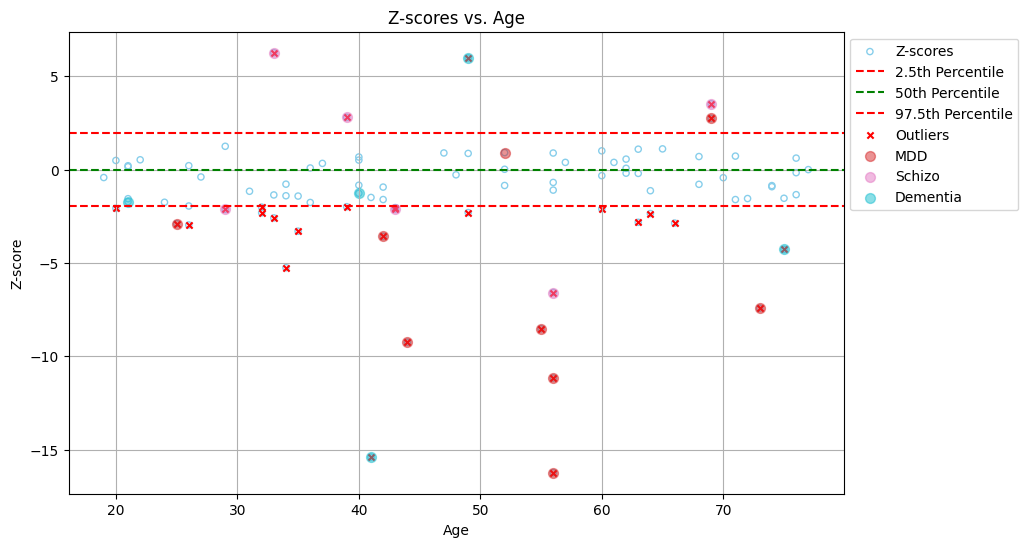

In [38]:
plot_z_scores_site(z_scores, site_df2, affected=site_df2['affected'])

#### Multisite transfer function

In [39]:
check_test_sites(train_data, df2)

Number of unique sites in the training set: 5
Number of unique sites in the test set: 9
Test sites not present in the training set: ['ZSCPY', 'KEMUB', 'HLMEG', 'OTLIE']
Number of extra sites: 4


,site,Length,Healthy,Morbidities
0,ZSCPY,93,71,"Len: 22, ['MDD', 'Schizo', 'Dementia']"
1,KEMUB,97,70,"Len: 27, ['Schizo', 'Dementia', 'MDD']"
2,HLMEG,92,66,"Len: 26, ['MDD', 'Dementia', 'Schizo']"
3,OTLIE,91,71,"Len: 20, ['Schizo', 'MDD', 'Dementia']"


Suggestion: Use 20% of 'None' samples from extra sites in the training data.
This can be done by calling the 'add_extra_site_data' function.


In [54]:
# Setting up the code files
y_val = 'y_thickness1'
x_vals = ['age', 'sex', 'site']
columns = x_vals.copy()
columns.extend([y_val])

main_model_path = "../results/site_transfer_main_model.rds"
main_traindata = train_data.loc[:, columns]

new_sites = ['ZSCPY', 'KEMUB', 'HLMEG', 'OTLIE']
selected_sites = 'HJDXM' # or list of sites of same length as new_site
fractions=0.2 # or list of fractions of same length as new_site
iterations=50

# Saving the results
save_folder = "../results/site_transfer_results"
file_name = "multi_site_transfer_results.pkl"

In [59]:
results = multisite_transfer(main_model_path, main_traindata, df2, new_sites, selected_sites, fractions, y_val, x_vals, iterations, save_folder, file_name)

0it [00:00, ?it/s]

new_site: ZSCPY, selected_site: HJDXM, fraction: 0.2
Model 'main_model' loaded from ../results/site_transfer_main_model.rds
Number of healthy samples in site ZSCPY: 71/93
Samples used for training the adjustment model for site ZSCPY: 14/93

GAMLSS-RS iteration 1: Global Deviance = 48.5338 
GAMLSS-RS iteration 2: Global Deviance = 47.9849 
GAMLSS-RS iteration 3: Global Deviance = 47.6015 
GAMLSS-RS iteration 4: Global Deviance = 47.2384 
GAMLSS-RS iteration 5: Global Deviance = 46.8956 
GAMLSS-RS iteration 6: Global Deviance = 46.5751 
GAMLSS-RS iteration 7: Global Deviance = 46.2533 
GAMLSS-RS iteration 8: Global Deviance = 45.9664 
GAMLSS-RS iteration 9: Global Deviance = 45.7177 
GAMLSS-RS iteration 10: Global Deviance = 45.4817 
GAMLSS-RS iteration 11: Global Deviance = 45.2674 
GAMLSS-RS iteration 12: Global Deviance = 45.0652 
GAMLSS-RS iteration 13: Global Deviance = 44.8629 
GAMLSS-RS iteration 14: Global Deviance = 44.662 
GAMLSS-RS iteration 15: Global Deviance = 44.4663 
GAML

1it [00:02,  2.16s/it]

new_site: KEMUB, selected_site: HJDXM, fraction: 0.2
Model 'main_model' loaded from ../results/site_transfer_main_model.rds
Number of healthy samples in site KEMUB: 70/97
Samples used for training the adjustment model for site KEMUB: 14/97

GAMLSS-RS iteration 1: Global Deviance = 47.307 
GAMLSS-RS iteration 2: Global Deviance = 46.8792 
GAMLSS-RS iteration 3: Global Deviance = 46.4823 
GAMLSS-RS iteration 4: Global Deviance = 45.9672 
GAMLSS-RS iteration 5: Global Deviance = 45.3918 
GAMLSS-RS iteration 6: Global Deviance = 44.7947 
GAMLSS-RS iteration 7: Global Deviance = 44.2692 
GAMLSS-RS iteration 8: Global Deviance = 43.8093 
GAMLSS-RS iteration 9: Global Deviance = 43.4286 
GAMLSS-RS iteration 10: Global Deviance = 43.1366 
GAMLSS-RS iteration 11: Global Deviance = 42.8922 
GAMLSS-RS iteration 12: Global Deviance = 42.6858 
GAMLSS-RS iteration 13: Global Deviance = 42.5092 
GAMLSS-RS iteration 14: Global Deviance = 42.3567 
GAMLSS-RS iteration 15: Global Deviance = 42.2247 
GAML

2it [00:04,  2.02s/it]

new_site: HLMEG, selected_site: HJDXM, fraction: 0.2
Model 'main_model' loaded from ../results/site_transfer_main_model.rds
Number of healthy samples in site HLMEG: 66/92
Samples used for training the adjustment model for site HLMEG: 13/92

GAMLSS-RS iteration 1: Global Deviance = 42.2671 
GAMLSS-RS iteration 2: Global Deviance = 41.6813 
GAMLSS-RS iteration 3: Global Deviance = 41.0973 
GAMLSS-RS iteration 4: Global Deviance = 40.5759 
GAMLSS-RS iteration 5: Global Deviance = 40.105 
GAMLSS-RS iteration 6: Global Deviance = 39.6734 
GAMLSS-RS iteration 7: Global Deviance = 39.2884 
GAMLSS-RS iteration 8: Global Deviance = 38.955 
GAMLSS-RS iteration 9: Global Deviance = 38.6826 
GAMLSS-RS iteration 10: Global Deviance = 38.4419 
GAMLSS-RS iteration 11: Global Deviance = 38.2347 
GAMLSS-RS iteration 12: Global Deviance = 38.054 
GAMLSS-RS iteration 13: Global Deviance = 37.8875 
GAMLSS-RS iteration 14: Global Deviance = 37.7459 
GAMLSS-RS iteration 15: Global Deviance = 37.6065 
GAMLSS

3it [00:06,  2.22s/it]

new_site: OTLIE, selected_site: HJDXM, fraction: 0.2
Model 'main_model' loaded from ../results/site_transfer_main_model.rds
Number of healthy samples in site OTLIE: 71/91
Samples used for training the adjustment model for site OTLIE: 14/91

GAMLSS-RS iteration 1: Global Deviance = 51.7771 
GAMLSS-RS iteration 2: Global Deviance = 50.2958 
GAMLSS-RS iteration 3: Global Deviance = 49.1186 
GAMLSS-RS iteration 4: Global Deviance = 48.1992 
GAMLSS-RS iteration 5: Global Deviance = 47.4355 
GAMLSS-RS iteration 6: Global Deviance = 46.8057 
GAMLSS-RS iteration 7: Global Deviance = 46.3038 
GAMLSS-RS iteration 8: Global Deviance = 45.8987 
GAMLSS-RS iteration 9: Global Deviance = 45.562 
GAMLSS-RS iteration 10: Global Deviance = 45.2921 
GAMLSS-RS iteration 11: Global Deviance = 45.0488 
GAMLSS-RS iteration 12: Global Deviance = 44.8482 
GAMLSS-RS iteration 13: Global Deviance = 44.6612 
GAMLSS-RS iteration 14: Global Deviance = 44.5137 
GAMLSS-RS iteration 15: Global Deviance = 44.3749 
GAML

4it [00:08,  2.21s/it]

Results saved to ../results/site_transfer_results/multi_site_transfer_results.pkl
